# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [90]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

%matplotlib inline

In [2]:
initial_data = pd.read_csv('zillow_data.csv')
print(len(initial_data))
initial_data.head(10)

14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500


In [3]:
# to view all NaN values for median housing price in zip code
columns = list(initial_data.columns)
nans = list(initial_data.isna().sum())
for item in zip(columns, nans):
    print(item)

('RegionID', 0)
('RegionName', 0)
('City', 0)
('State', 0)
('Metro', 1043)
('CountyName', 0)
('SizeRank', 0)
('1996-04', 1039)
('1996-05', 1039)
('1996-06', 1039)
('1996-07', 1039)
('1996-08', 1039)
('1996-09', 1039)
('1996-10', 1039)
('1996-11', 1039)
('1996-12', 1039)
('1997-01', 1039)
('1997-02', 1039)
('1997-03', 1039)
('1997-04', 1039)
('1997-05', 1039)
('1997-06', 1039)
('1997-07', 1038)
('1997-08', 1038)
('1997-09', 1038)
('1997-10', 1038)
('1997-11', 1038)
('1997-12', 1038)
('1998-01', 1036)
('1998-02', 1036)
('1998-03', 1036)
('1998-04', 1036)
('1998-05', 1036)
('1998-06', 1036)
('1998-07', 1036)
('1998-08', 1036)
('1998-09', 1036)
('1998-10', 1036)
('1998-11', 1036)
('1998-12', 1036)
('1999-01', 1036)
('1999-02', 1036)
('1999-03', 1036)
('1999-04', 1036)
('1999-05', 1036)
('1999-06', 1036)
('1999-07', 1036)
('1999-08', 1036)
('1999-09', 1036)
('1999-10', 1036)
('1999-11', 1036)
('1999-12', 1036)
('2000-01', 1036)
('2000-02', 1036)
('2000-03', 1036)
('2000-04', 1036)
('2000-05

In [4]:
initial_data[initial_data['2014-06'].isna()].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2946,73623,35810,Huntsville,AL,Huntsville,Madison,2947,NaN,NaN,NaN,...,61000,61000,61100,61900,62800,63200,63700,65200,67500,69400
3330,58630,2116,Boston,MA,Boston,Suffolk,3331,NaN,NaN,NaN,...,1931100,1995600,2031100,2049600,2057800,2064500,2037600,2056900,2106500,2136500
6153,73629,35816,Huntsville,AL,Huntsville,Madison,6154,NaN,NaN,NaN,...,61500,62500,62800,63300,64100,65100,66600,68700,70400,71300
7587,78091,46320,Hammond,IN,Chicago,Lake,7588,NaN,NaN,NaN,...,66000,67900,68200,68700,69600,69400,68500,68500,68200,67200
7635,78566,47371,Portland,IN,NaN,Jay,7636,NaN,NaN,NaN,...,86300,86600,87400,88200,89100,90300,90400,89100,88000,88100


In [5]:
def fix_zipcodes(zipcode):
    if len(zipcode) == 5:
        return zipcode
    else:
        return '0'+zipcode

In [6]:
cut_data = initial_data.drop(['RegionID', 'City', 'State', 'CountyName', 'SizeRank', 'Metro'], axis=1)
cut_data.rename({'RegionName': 'zipcode'}, axis=1, inplace=True)
cut_data['zipcode'] = cut_data.zipcode.astype(str)
cut_data['zipcode'] = cut_data['zipcode'].apply(lambda z: fix_zipcodes(z))
cut_data[cut_data.zipcode == '95123']
len(cut_data)

14723

# Step 2: Data Preprocessing

In [7]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [8]:
cut_data.columns = [cut_data.columns[0]] + list(get_datetimes(cut_data))

# Step 3: Reshape from Wide to Long Format

In [9]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 
                                  'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    return melted.groupby('time').agg({'value':'median'})

In [10]:
monthly_medians = melt_data(initial_data)

In [11]:
monthly_medians.head()

,value
time,
1996-04-01,99500.0
1996-05-01,99500.0
1996-06-01,99700.0
1996-07-01,99700.0
1996-08-01,99800.0


In [12]:
zipcodes = []
time_series = []
for row in range(len(cut_data)):
    zipcodes.append(cut_data.iloc[row]['zipcode'])
    series = pd.DataFrame(cut_data.iloc[row].iloc[1:]).rename({row:'values'}, axis=1)
    time_series.append(series)

In [13]:
for zipcode in time_series:
    for j in range(len(zipcode)):
        if np.isnan(zipcode.iloc[-1-j].values[0]):
            base = zipcode.iloc[-j].values[0]
            ratio = monthly_medians.iloc[-1-j].values[0] / monthly_medians.iloc[-j].values[0]
            zipcode.iloc[-1-j] = round(base * ratio, 2)

In [14]:
len(zipcodes)

14723

In [15]:
len(time_series)

14723

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

In [16]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [23]:
min(monthly_medians.values)

array([99500.])

We used http://www.in2013dollars.com/1996-dollars-in-2018?amount=99500 to get a table for inflation's effect on prices from 1996 (the beginning of our data set) to 2018 (the end of our dataset)

In [24]:
inflation_data = pd.read_csv('inflation_data.csv')
inflation_data['year'] = pd.to_datetime(inflation_data['year'], format='%Y')
inflation_data.drop('inflation rate', axis=1, inplace=True)
inflation_data.set_index('year', inplace=True)
inflation_data.head()

,amount
year,
1996-01-01,99500.000000
1997-01-01,101782.982792
1998-01-01,103368.387508
1999-01-01,105651.370300
2000-01-01,109202.676864


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


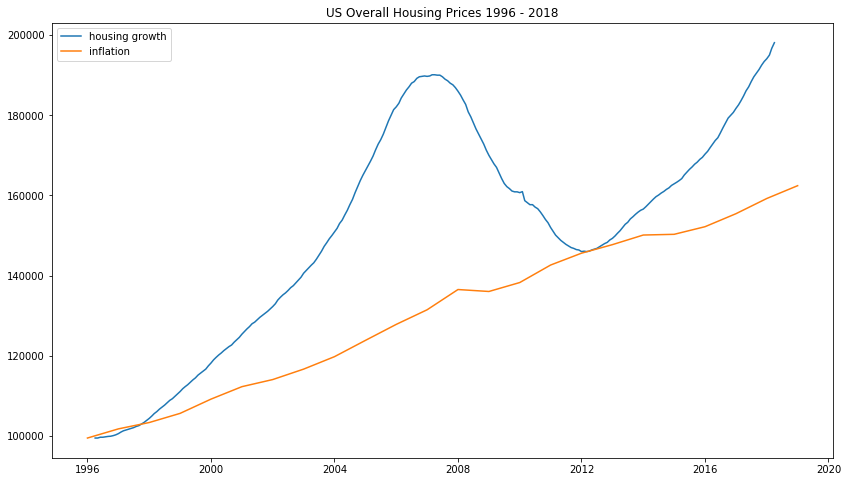

In [25]:
plt.figure(figsize=(14,8))
plt.plot(monthly_medians, label='housing growth')
plt.plot(inflation_data, label='inflation')
plt.title('US Overall Housing Prices 1996 - 2018')
plt.legend()
plt.show()

In [56]:
def plot_growth(start_year='1996', end_year='2018', top_or_bottom='top', how_many=5):
    percent_growth_by_zip = []
    for zipcode in time_series:
        percent_for_zip = (zipcode.loc[end_year].values[0][0] - zipcode.loc[start_year].values[0][0]) / zipcode.loc[start_year].values[0][0]
        percent_growth_by_zip.append(percent_for_zip)
        
    start = 0
    end = len(percent_growth_by_zip)
    start = -how_many if top_or_bottom == 'top' else start
    end = how_many if top_or_bottom == 'bottom' else end
    
    indexes = sorted(range(len(percent_growth_by_zip)), 
                     key=lambda i: percent_growth_by_zip[i], reverse=False)[start:end]
            
    values_to_print = []
    plt.figure(figsize=(14,8))
    for i in indexes:
        values_to_print.append([zipcodes[i], percent_growth_by_zip[i]])
        plt.plot(time_series[i][start_year:end_year], 
                 label=str(zipcodes[i])+' - '+str(initial_data.iloc[i]['City']+ \
                                        ', '+str(initial_data.iloc[i]['State'])))
    plt.plot(monthly_medians[start_year:end_year], label='Median growth')
    plt.legend()
    plt.show
    for j in range(len(values_to_print)):
        print('Growth rate for zipcode', values_to_print[j][0], ':', round(values_to_print[j][1]*100, 2), '%')

Growth rate for zipcode 20001 : 749.57 %
Growth rate for zipcode 80449 : 755.33 %
Growth rate for zipcode 90291 : 770.42 %
Growth rate for zipcode 11930 : 829.26 %
Growth rate for zipcode 11975 : 859.37 %
Growth rate for zipcode 11215 : 914.13 %
Growth rate for zipcode 11216 : 954.21 %
Growth rate for zipcode 07302 : 960.42 %
Growth rate for zipcode 11222 : 1013.81 %
Growth rate for zipcode 11211 : 1023.2 %


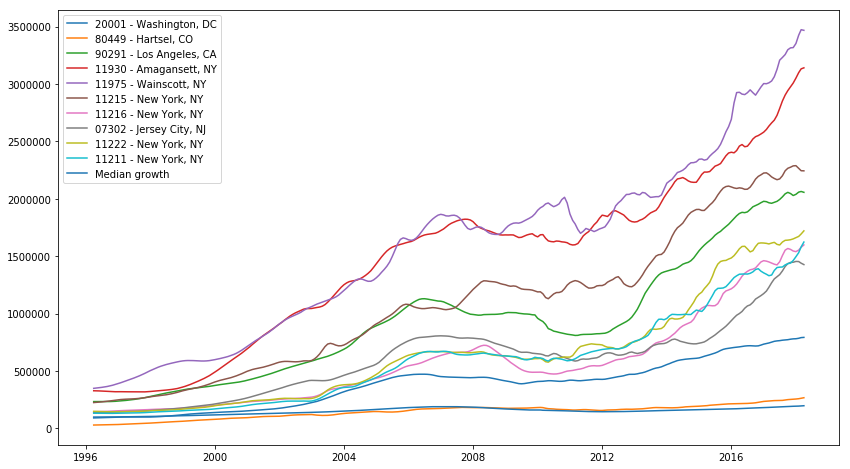

In [57]:
plot_growth(how_many=10)

Growth rate for zipcode 94303 : 145.26 %
Growth rate for zipcode 94040 : 148.53 %
Growth rate for zipcode 80010 : 149.07 %
Growth rate for zipcode 94043 : 150.52 %
Growth rate for zipcode 11216 : 152.12 %
Growth rate for zipcode 58801 : 158.03 %
Growth rate for zipcode 11222 : 162.28 %
Growth rate for zipcode 30032 : 165.45 %
Growth rate for zipcode 94301 : 166.09 %
Growth rate for zipcode 85035 : 183.49 %


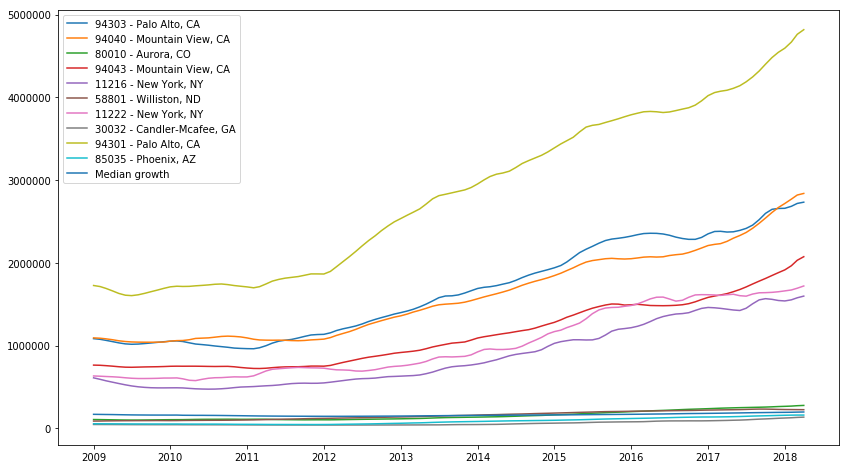

In [58]:
plot_growth(start_year='2009', end_year='2018', how_many=10)

In [60]:
percent_growth_by_zip = []
for zipcode in time_series:
    percent_for_zip = (zipcode.loc['2018'].values[0][0] - zipcode.loc['2010'].values[0][0]) / zipcode.loc['2009'].values[0][0]
    percent_growth_by_zip.append(percent_for_zip)
    

In [61]:
indexes = sorted(range(len(percent_growth_by_zip)), 
                 key=lambda i: percent_growth_by_zip[i], reverse=False)
print(indexes[:5])

[5278, 10050, 7402, 13440, 5690]
[0.25186361969937676, 0.5716403162055336, 0.301986218078638, 0.22273324572930356, -0.01069078947368421]


In [147]:
top_indexes = indexes[int(len(indexes)*.99):]
len(top_quarter_indexes)

148

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

In [145]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(time_series, arima_order):
    # prepare training dataset
    time_series_post_crash = time_series['2010':].squeeze()
    train_size = int(len(time_series_post_crash) * 0.66)
    train, test = time_series_post_crash[0:train_size], time_series_post_crash[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [146]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = 100000000.0, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [148]:
warnings.filterwarnings("ignore")
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 3)
best_post_crash_arima = []
for index in top_indexes[:3]:
    print('Index:', index, 'Zipcode:', zipcodes[index])
    pdq = evaluate_models(time_series[index], p_values, d_values, q_values)
    print()
    best_post_crash_arima.append({'index': index, 'zipcode': zipcodes[index], 'pdq': pdq})

Index: 4678 Zipcode: 29403
Best ARIMA(3, 2, 2) MSE=1512534.503

Index: 5323 Zipcode: 75235
Best ARIMA(1, 1, 2) MSE=934553.128

Index: 1383 Zipcode: 94539
Best ARIMA(3, 2, 2) MSE=13460111.006



In [149]:
best_post_crash_arima

[{'index': 4678, 'zipcode': '29403', 'pdq': (3, 2, 2)},
 {'index': 5323, 'zipcode': '75235', 'pdq': (1, 1, 2)},
 {'index': 1383, 'zipcode': '94539', 'pdq': (3, 2, 2)}]

In [157]:
future_percent_growth_by_zip_5_year = []
for entry in best_post_crash_arima:
    history = time_series[entry['index']].astype('float32')['2010':].squeeze()
    model = ARIMA(history, order=entry['pdq'])
    model_fit = model.fit(disp=0)
    future_percent_for_zip = (model_fit.forecast(12*5)[0][-1] - history[-1]) / history[-1]
    future_percent_growth_by_zip_5_year.append({'zipcode': entry['zipcode'], 
                                                'growth_predict': round(future_percent_for_zip*100, 2)})

In [158]:
future_percent_growth_by_zip_5_year

[{'zipcode': '29403', 'growth_predict': 54.95},
 {'zipcode': '75235', 'growth_predict': 25.53},
 {'zipcode': '94539', 'growth_predict': 19.83}]

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.

# Working Zone

In [ ]:
for zipcode in time_series:
    for i in range(1, len(zipcode)+1):
        if zipcode.iloc[-i].values == 0:
            zipcode.iloc[-i] = round(float(zipcode.iloc[-i+1].values * (melted_data.iloc[-i].values / 
                                                                        melted_data.iloc[-i+1].values)), 0)

In [ ]:
percent_growth_by_zip = []
for zipcode in time_series:
    percent_for_zip = zipcode.loc['1996'].values[0][0] / zipcode.loc['2008'].values[0][0]
    percent_growth_by_zip.append(percent_for_zip)

In [ ]:
indexes = sorted(range(len(percent_growth_by_zip)), key=lambda i: percent_growth_by_zip[i], reverse=True)[:5]
indexes

In [ ]:
plt.figure(figsize=(14,8))
for i in indexes:
    plt.plot(time_series[i], label=str(zipcodes[i]))
plt.plot(monthly_medians, label='median growth')
plt.legend()
plt.show

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 13)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

In [137]:
# evaluate parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(time_series[0], p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=22524201798.709
ARIMA(0, 0, 1) MSE=5644131313.729
ARIMA(0, 1, 0) MSE=15252790.551
ARIMA(0, 1, 1) MSE=6661495.112
ARIMA(0, 2, 0) MSE=11361751.352
ARIMA(0, 2, 1) MSE=7119207.778
ARIMA(1, 0, 0) MSE=25955172.117
ARIMA(1, 1, 0) MSE=9901379.810
ARIMA(1, 1, 1) MSE=5618165.173
ARIMA(1, 2, 0) MSE=9980796.512
ARIMA(1, 2, 1) MSE=7240391.272
ARIMA(1, 2, 2) MSE=6003944.604
ARIMA(2, 0, 0) MSE=10935372.639
ARIMA(2, 1, 0) MSE=6851567.523
ARIMA(2, 2, 0) MSE=6638567.862
ARIMA(2, 2, 1) MSE=6207464.714
ARIMA(2, 2, 2) MSE=5314251.194
ARIMA(3, 1, 1) MSE=5182165.450
ARIMA(3, 1, 2) MSE=3986375.863
ARIMA(3, 2, 0) MSE=6989774.563
ARIMA(3, 2, 1) MSE=6390995.761
ARIMA(4, 1, 0) MSE=5924929.777
ARIMA(4, 1, 1) MSE=5379103.854
ARIMA(4, 2, 0) MSE=4774411.464
ARIMA(4, 2, 1) MSE=5501008.573
ARIMA(4, 2, 2) MSE=5552039.614
ARIMA(5, 1, 0) MSE=4630496.045
ARIMA(5, 2, 0) MSE=5282916.710
ARIMA(5, 2, 1) MSE=5401434.905
ARIMA(6, 1, 0) MSE=5004262.883
ARIMA(6, 1, 1) MSE=4746351.866
ARIMA(6, 2, 0) MSE=5302217.7